# REINFORCE

**Mountain Car MDP**


The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. We will experiment with the continouse version in this one.


![Mountain Car](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis and the velocity of the car.

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

A negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

You can read more the MountainCar Continous environment [here](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

## Continous Action Spaces

It's conceptually the same as for discrete action spaces. In discrete action spaces you have a discrete distribution like the categorical distribution and you calculate the log pi probabilities using its mass function. In continuous action spaces you use a continuous distribution like the Gaussian distribution and calculate the log pi “probabilities” using its density function. Everything else is the same.

So instead of having network that outputs the parameters for a categorical distribution, you have a network that outputs parameters for (usually) a Gaussian distribution (i.e. the mean and standard deviation)

But, usually we just output the mean using a neural network, and have a separate set of learnable parameters for std (in log space) for each action. For example, if we 3 continous actions then we will have a neural network which will output the means for these actions and then separate 3 parameters which will represent the log std of these actions. We still learn these log std but they are not dependent on state. We just have a log std for each action.

Other approaches for std include:
- Having a std as output of neural network just as the mean.
- Initializing some std for all actions at start and then steadily decrease if using a std_decay hyperparameter as the training progresses.


You can use any appraoch you like.



## Reinforce

REINFORCE is an elegant algorithm for maximizing the expected return. We sample a trajectory $\tau$ . If we get a high reward, we try to make it more likely. If we get a low reward, we try to make it less likely.

We just need a policy that maximizes the expected return and we can do this by Gradient Ascent on Policy parameters.

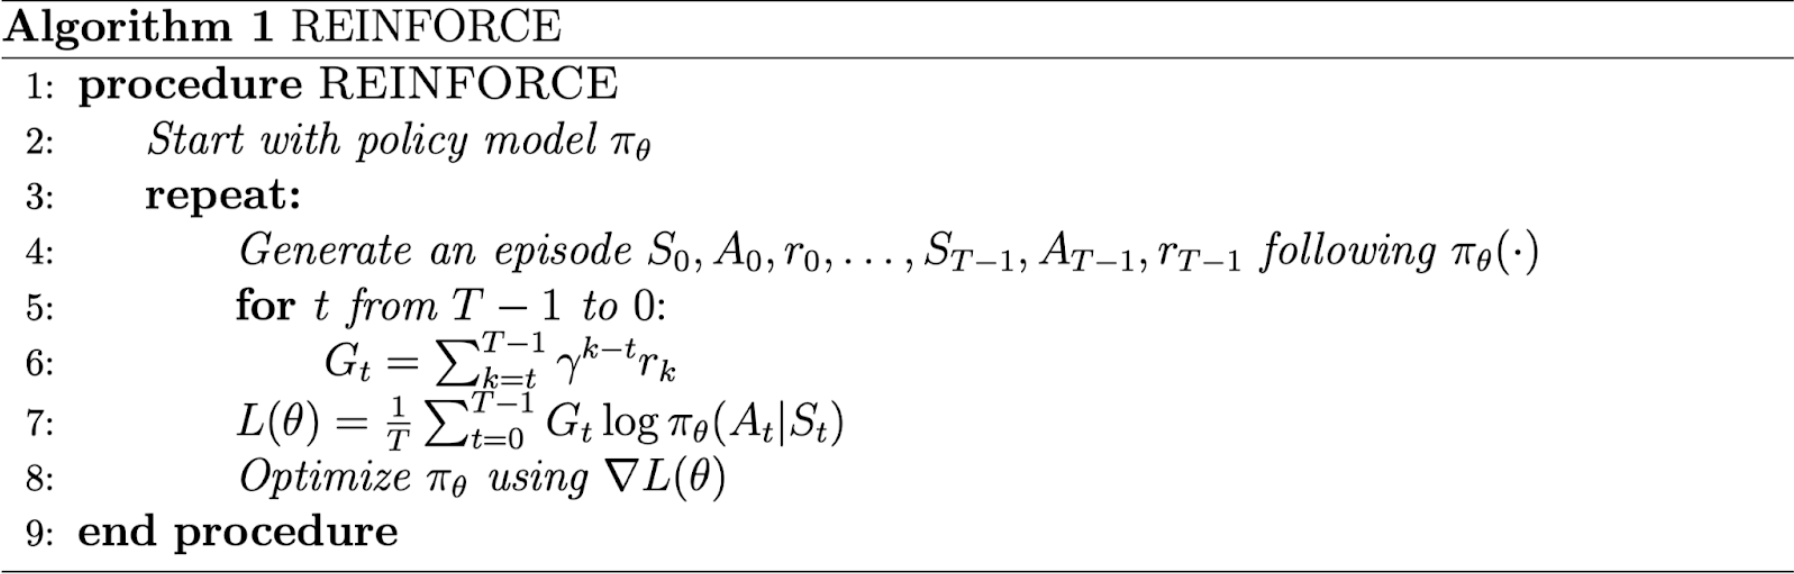




### Hints
- Try to use at least a 3 to 4 layer network with tanh activation at last layer.
- Use high value of gamma and max_steps
- Try to understand the reward function and think how the agent can get stuck in a non-optimal reward trajectory.

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal

In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Create the environment
env = gym.make('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Policy Network

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
state size: 2
action size: 1
Episode 1: Reward = -16.032342664636897
Episode 2: Reward = -17.424636312579445
Episode 3: Reward = -19.696295389630453
Episode 4: Reward = -22.31644278025771
Episode 5: Reward = -19.819998154669115
Episode 6: Reward = -21.135874601366883
Episode 7: Reward = -19.555655767009526
Episode 8: Reward = -20.11758376648764
Episode 9: Reward = -20.0195869726445
Episode 10: Reward = -21.002909369467037
Episode 11: Reward = -17.16538571765315
Episode 12: Reward = -18.354388243490643
Episode 13: Reward = -14.964852253843018
Episode 14: Reward = -16.569993021104942
Episode 15: Reward = -17.138956101506192
Episode 16: Reward = -12.593162971038877
Episode 17: Reward = -15.040737002188305
Episode 18: Reward = -12.053287949270866
Episode 19: Reward = -14.237071770259565
Episode 20: Reward = -12.938507584400185
Episode 21: Reward = -11.992487440343737
Episode 22: Re

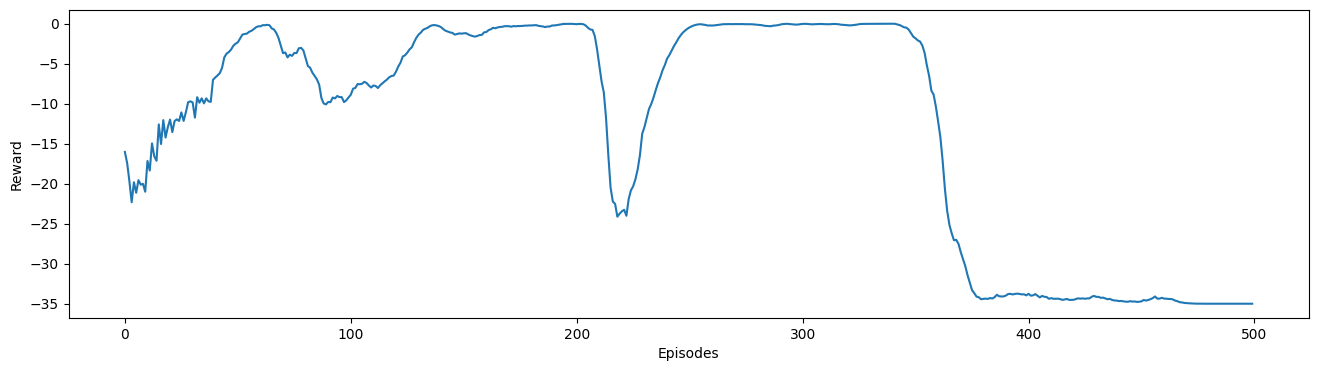

In [9]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the environment
env = gym.make('MountainCarContinuous-v0')

# A neural network for policy
# It takes the state as input and predicts the probability of each action
class Policy(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Policy, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 128)
        self.mean_layer = nn.Linear(128, n_actions)
        self.std_layer = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        mean = self.mean_layer(x)
        std = torch.clamp(F.softplus(self.std_layer(x)), 1e-5, 2)  # Ensure a reasonable range for standard deviation
        return torch.tanh(mean), std

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        mean, std = self.forward(state)
        m = Normal(mean, std)
        action = m.sample()
        return action.item(), m.log_prob(action)

# Here, we will specify the hyperparameters

total_episodes = 400        # Total training episodes
max_steps = 300              # Max steps per episode
learning_rate = 1e-3         # Learning rate
gamma = 0.99                # Discounting rate

## OBSERVATIONS
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('state size:', state_size)
print('action size:', action_size)

## POLICY NETWORK
# Initialize policy network
policy_net = Policy(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

## TRAINING
scores = []
for episode in range(1, total_episodes + 1):
    saved_log_probs = []
    rewards = []
    state = env.reset()
    # collect trajectory
    for t in range(max_steps):
        # sample action and its log probability from policy
        action, log_prob = policy_net.act(state)
        # save the log probability for later use
        saved_log_probs.append(log_prob)
        state, reward, done, _ = env.step([action])  # Wrap the continuous action in a list
        rewards.append(reward)
        if done:
            break

    scores.append(sum(rewards))

    # Compute the discounted returns at each timestep
    returns = np.zeros(len(rewards))
    disc_return = 0
    for t in reversed(range(len(rewards))):
        disc_return = gamma * disc_return + rewards[t]
        returns[t] = disc_return

    # Standardization of the returns is employed to make training more stable
    eps = np.finfo(np.float32).eps.item()
    returns = torch.tensor(returns).to(device)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    # Calculating policy loss and updating the policy network
    optimizer.zero_grad()
    policy_loss = torch.stack([-log_prob * disc_return for log_prob, disc_return in zip(saved_log_probs, returns)]).sum()
    policy_loss.backward()
    optimizer.step()

    print(f"Episode {episode}: Reward = {scores[-1]}")

## PLOTTING
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()


observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
state size: 2
action size: 1
Episode 1: Reward = 74.43628599493428
Episode 2: Reward = -1.929051012399729
Episode 3: Reward = 10.514589091473654
Episode 4: Reward = 95.19779057343196
Episode 5: Reward = 44.08426535018661
Episode 6: Reward = 76.9434789663652
Episode 7: Reward = 95.2524450979658
Episode 8: Reward = 10.755275897641216
Episode 9: Reward = -21.509414997881258
Episode 10: Reward = 178.0485952982495
Episode 11: Reward = -36.384631289791585
Episode 12: Reward = 185.185303313573
Episode 13: Reward = 39.6634389621657
Episode 14: Reward = 182.5542402733074
Episode 15: Reward = 246.79461026078485
Episode 16: Reward = 143.09782199049062
Episode 17: Reward = 74.02469279624586
Episode 18: Reward = 73.56946235179444
Episode 19: Reward = 66.12492616819735
Episode 20: Reward = 40.62556766414666
Episode 21: Reward = 98.10678430043932
Episode 22: Reward = 168.13627133015757
Episod

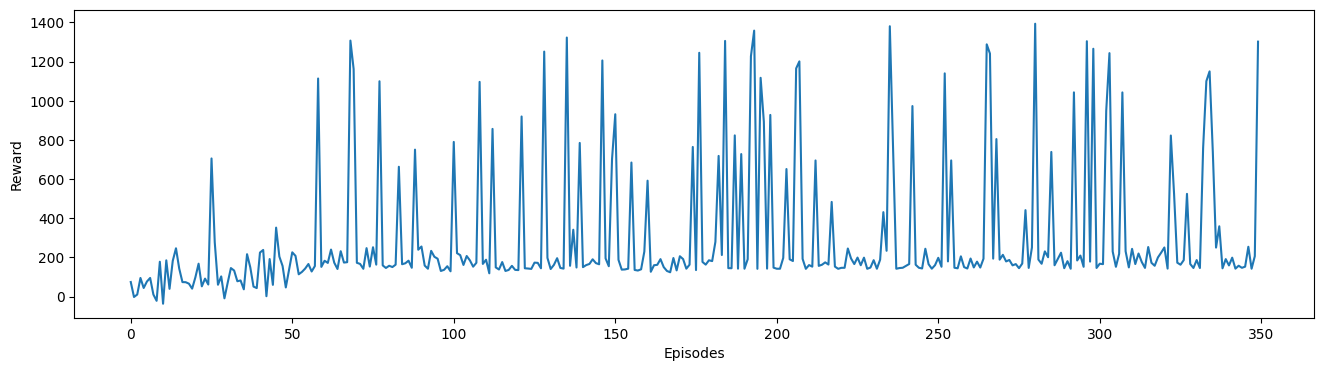

In [20]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the environment
env = gym.make('MountainCarContinuous-v0')

# A neural network for policy
# It takes the state as input and predicts the probability of each action
class Policy(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Policy, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 256)
        self.layer4 = nn.Linear(256, 512)
        self.mean_layer = nn.Linear(512, n_actions)
        self.std_layer = nn.Linear(512, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        mean = self.mean_layer(x)
        std = torch.clamp(F.softplus(self.std_layer(x)), 1e-5, 2)  # Ensure a reasonable range for standard deviation
        return torch.tanh(mean), std

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        mean, std = self.forward(state)
        m = Normal(mean, std)
        action = m.sample()
        return action.item(), m.log_prob(action)

# Custom reward function for encouraging right movement and reaching the goal
def get_reward(state, rightmost_position):
    # Get the position of the car
    position_x, position_y = state[0], state[1]
    # print(f"x axis = {position_x}")
    # print(f"y axis = {position_y}")

    # Calculate the distance to the top-right corner (goal position)
    distance_to_goal = np.sqrt((position_x - 0) ** 2 + (position_y - 0) ** 2) # 0.5

    # Calculate the reward based on right movement and approaching the goal
    reward = position_x - abs(position_y)

    # print(f"x axis = {position_x}")
    # print(f"y axis = {position_y}")
    # print(f"reward = {reward}\n")

    # Add high reward for reaching the right side of the board
    if position_x >= 0:
        reward += 10.0

    # Encourage oscillation behavior by adding a term based on the rightmost position observed during the episode
    oscillation_reward = 2.0 * np.sin(5 * (position_x - rightmost_position))

    # Combine the rewards
    reward += oscillation_reward

    # Encourage moving towards the goal by adding a term based on the distance to the goal
    goal_reward = 2.0 - distance_to_goal
    reward += goal_reward

    return reward

# Here, we will specify the hyperparameters

total_episodes = 350        # Total training episodes
max_steps = 400              # Max steps per episode
learning_rate = 0.001         # Learning rate
gamma = 0.99                # Discounting rate

## OBSERVATIONS
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('state size:', state_size)
print('action size:', action_size)

## POLICY NETWORK
# Initialize policy network
policy_net = Policy(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

## TRAINING
scores = []
for episode in range(1, total_episodes + 1):
    saved_log_probs = []
    rewards = []
    state = env.reset()
    rightmost_position = state[0]  # Initialize the rightmost position as the starting position
    # num_steps = 0  # Initialize the number of steps taken in the episode
    # collect trajectory
    for t in range(max_steps):
        # num_steps += 1  # Increment the step counter
        # sample action and its log probability from policy
        action, log_prob = policy_net.act(state)
        # save the log probability for later use
        saved_log_probs.append(log_prob)
        state, _, done, _ = env.step([action])  # Wrap the continuous action in a list

        # Update the rightmost position observed during the episode
        rightmost_position = max(rightmost_position, state[0])

        # Calculate the new reward using the custom reward function
        reward = get_reward(state, rightmost_position)
        rewards.append(reward)
        if done:
            break

    scores.append(sum(rewards))

    # Compute the discounted returns at each timestep
    returns = np.zeros(len(rewards))
    disc_return = 0
    for t in reversed(range(len(rewards))):
        disc_return = gamma * disc_return + rewards[t]
        returns[t] = disc_return

    # Standardization of the returns is employed to make training more stable
    eps = np.finfo(np.float32).eps.item()
    returns = torch.tensor(returns).to(device)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    # Calculating policy loss and updating the policy network
    optimizer.zero_grad()
    policy_loss = torch.stack([-log_prob * disc_return for log_prob, disc_return in zip(saved_log_probs, returns)]).sum()
    policy_loss.backward()
    optimizer.step()

    print(f"Episode {episode}: Reward = {scores[-1]}")


## PLOTTING
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()


### Hyperparameters

### Training

### Visualization

In [27]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML, display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER'] = 'dummy'

os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name, policy_net, max_steps=400):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _ = policy_net.act(state)
        next_state, reward, done, info = env.step([action])  # Wrap the continuous action in a list
        state = next_state
        if done:
            break
    vid.close()
    env.close()

# Assuming 'policy_net' is your trained policy network
show_video_of_model("MountainCarContinuous-v0", policy_net)

# This will display the video after running the visualization function
show_video("MountainCarContinuous-v0")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WAR